In [1]:
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torchvision
import torchvision.transforms as transforms

In [3]:
import os
os.environ['TORCH_HOME'] = './torch_home'

# for path for pretrained paths

### Not doing any training here. Using pretrained models for occlusion analysis and filter visualization. Can do  in cpu itself.

## Custom Dataset

In [4]:
# Transforms
transform = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
# those normalization numbers - mean, SD of 3 channels of the entire imagenet dataset.

# ImageFolder
custom_dataset = torchvision.datasets.ImageFolder(root='./data/image_data', 
                                                  transform=transform)




In [5]:
# Dataloader

batch_size=4
# dataloader - (from the dataset)
dataloader = torch.utils.data.DataLoader(custom_dataset, 
                                         batch_size=batch_size, 
                                         shuffle=True)

In [6]:
# read the label file
with open("data/imagenet_labels.txt") as f:
    classes = eval(f.read())

# eval("expression") - runs the expression
    
# print(classes)

## Utils

In [7]:
# function to display an image_grid
# after doing std, mean correction and transposing
def show_image(img, batch_size, title):
    
    # inverse correction for normalisation
    std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    npimg = np.multiply(img.numpy(), std_correction) + mean_correction #np.multiply - braodcast
    
    plt.figure(figsize=(batch_size * 4, 4))
    plt.axis('off')
    npimg = np.transpose(npimg, (1, 2, 0)) # transposing for matplotlib
    plt.imshow( (npimg*255).astype(np.uint8) )
    # casting to uint8 to avoid clipping warning
    plt.title(title)
    plt.show()
    

# function to show the next batch using dataloader
# along with predictions as title

def show_image_batch(dataloader, model):
    image_batch, _ = next(iter(dataloader))
    
    batch_size = len(image_batch) # getting batch_size from the loaded batch
    
    output_batch = model(image_batch) #prediction
    _, preds = torch.max(output_batch.data, 1)
        
    img = torchvision.utils.make_grid(image_batch) # make grid
    show_image(img, batch_size, title=[classes[x.item()] for x in preds])
    # a list is pased as title. The list gets printed
    
    # prediction is printed. Not the true label.
    # True label indexes are different here.
    
    return image_batch, preds #also return input, output

## Model (pretrained vgg)

In [8]:
vgg = torchvision.models.vgg16(weights='DEFAULT')

# pretrined on the imagenet dataset

# data we have for testing is also from imagenet.
# so we don't want to do any more partial training.

In [9]:
vgg.eval() # set model in the eval mode.
# as we are going to do only inference

# things like dropout which are only used in training, .. are turned off.

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Inference

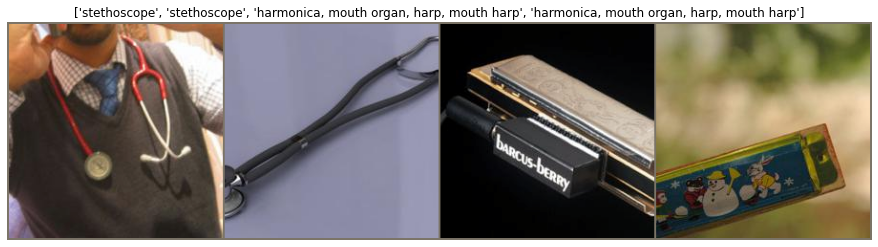

In [10]:
images, preds = show_image_batch(dataloader, vgg)

In [11]:
# images - returned by the above function.

outputs = vgg(images)
print(outputs.shape)
# output is a vector of size 1000. 
# probability distribution of classes.(on taking softmax) 
# as softmax is not in the model
# for loss - softmax of output is taken - and cross entropy is found with one-hot.

outputs = nn.functional.softmax(outputs, dim=1) # applying softmax fn on the ouput of model. 
# as no softmax in the model part. it comes in the loss part.
# now probability distribution of classes

# softmax value => probability

prob_no_occ, pred = torch.max(outputs, 1)
print(prob_no_occ) # max prob in the output vectors

# max prob of first image in the batch
prob_no_occ = prob_no_occ[0].item()
print(prob_no_occ) # prob predicted when no occlusion.

torch.Size([4, 1000])
tensor([0.7618, 0.9480, 0.9985, 0.7381], grad_fn=<MaxBackward0>)
0.7618119716644287


# Occlusion analysis

=> change input image - pass thr' model - get prob.  
=> occlusion patch around a pixel.   
=> heat map - with value at a coordinate = prob(at original-label-index) when occlusion patch around corresponding coord.  

No overlap in the occlusions. Stride that way.  
Heat map has probability at label-index (NOT the max prob)  
Probability predicted for that label - when image is occluded.

In [12]:
def occlusion(model, image, label, occ_size=50, occ_stride=50, occ_pixel=0.5):
    
    # pass a single-image-"BATCH" , label of the image(integer).
    
    # occ_size - size of occlusion
    # occ_stride - stride (such that no overlap)
    # occ_pixel - value of color replaced in the location
    
    img_width, img_height = image.shape[-2], image.shape[-1] 
    # using negative indices. this works both when there is batching and no batching.
    # ie, even in case its a batch of single image
    
    # headmap shape
    hm_height = int(np.ceil( (img_height-occ_size)/occ_stride) )
    hm_width = int(np.ceil( (img_width-occ_size)/occ_stride) )
    
    heatmap = torch.zeros((hm_height, hm_width))
    
    # iterate through heatmap
    for h in range(0, hm_height):
        for w in range(0, hm_width):
            
            # corresponding patch start-end in image
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(img_height, h_start + occ_size)
            w_end = min(img_width, w_start + occ_size)
            
            # if ends outside image dimension
            if (w_end) >= img_width or (h_end) >= img_height:
                continue # next iteration
            
            input_image = image.clone().detach() # clone => deep copy
            # copy. Otherwise original image will be modified.
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel # occluded
            
            output = model(input_image) # inference on occluded image      
            # softmax of output for probability
            output = nn.functional.softmax(output, dim=1) 
            
            prob = output.tolist()[0][label] 
            # not max. prob corresponding to the one that we are seeing.
            
            heatmap[h, w] = prob 
            # plotting the prob itself. (in theory we took diff from original) 

    return heatmap

Using one of the images for occlusion analysis. Image_batch, pred_batch is returned by the function.

In [13]:
image, pred = images[0], preds[0].item()
# image is a single-image
# make it a batch of single image - to match the dimensions
image = torch.unsqueeze(image, 0)
print(image.shape)
print(pred)

torch.Size([1, 3, 224, 224])
823


In [14]:
heatmap = occlusion(vgg, image, pred, 32, 14)

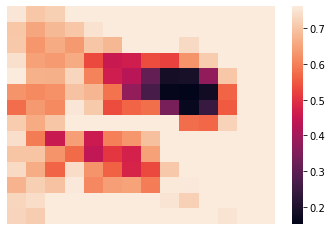

In [15]:
hm_plot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
# setting max as prob when no occlusion.

Some other part(which we know are irrelevant) - also may play a role in the prediction. These are things we don't understand well enough. The networks are very complex.